In [1]:
import numpy as np
from typing import Tuple, List, Union

import numpy.random as npr
import random
from numpy.linalg import inv

#from causaltensor.cauest import DC_PR_with_suggested_rank
#from causaltensor.cauest import std_debiased_convex
#from causaltensor.cauest import DC_PR_auto_rank

# import causaltensor as ct
from helper_function import *
from algorithm import *
import ray
import time
import matplotlib.pyplot as plt
import pdb
import pandas as pd

vector = Union[np.ndarray]
entry_matrix = Tuple[int, int, float]

c:\Users\amdeep\Anaconda3\envs\bond37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-29 16:52:52,000	INFO util.py:90 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
n_iters = 50

ray.shutdown()
ray.init()

start_time = time.time()
all_results_no_instrument = ray.get(
   [
       worker.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-09-29 15:20:52,776	INFO worker.py:1642 -- Started a local Ray instance.


In [8]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
n_iters = 5

ray.shutdown()
ray.init()

start_time = time.time()
all_results_ols = ray.get(
   [
       worker_ols.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-09-29 16:43:52,416	INFO worker.py:1642 -- Started a local Ray instance.


In [3]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
n_iters = 5

ray.shutdown()
ray.init()

start_time = time.time()
# tau_arr = np.zeros(n_iters)
# for t in range(n_iters):
#     tau_arr[t] = worker_2sls(t, d1, d2, r, tau, noise_sd)


all_results_ols = ray.get(
   [
       worker_ols.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-09-29 16:53:00,050	INFO worker.py:1642 -- Started a local Ray instance.


In [32]:
def worker_ols(seed, d1, d2, r, tau, noise_sd):
    b, z_vec, treat_mat, outcome_mat = generate_dat(seed, d1, d2, r, tau, noise_sd)
    treat_vec = np.c_[np.ones(d1*d2).reshape([-1,1]),treat_mat.reshape([d1*d2, 1])]
    print(treat_vec.shape)
    outcome_vec = outcome_mat.reshape([d1*d2, 1])
    _,tau = inv(treat_vec.T @ treat_vec) * (treat_vec.T @ outcome_vec)
    return tau
worker_ols(np.random.randint(1000), d1, d2, r, tau, noise_sd)

(10000, 2)


array([-0.5738893,  3.6368143])

In [38]:
def worker_2sls(seed, d1, d2, r, tau, noise_sd):
    b, z_vec, treat_mat, outcome_mat = generate_dat(seed, d1, d2, r, tau, noise_sd)
    h_z_vec = opt_instrument(z_vec, treat_mat)
    P_Z = h_z_vec.dot(inv(h_z_vec.T.dot(h_z_vec)).dot(h_z_vec.T))
    treat_vec = np.c_[np.ones(d1*d2).reshape([-1,1]),P_Z @treat_mat.reshape([d1*d2, 1])]
    outcome_vec = outcome_mat.reshape([d1*d2, 1])
    _,tau = inv(treat_vec.T @  treat_vec) * (treat_vec.T @  outcome_vec)
    return tau
worker_2sls(np.random.randint(1000), d1, d2, r, tau, noise_sd)

array([-0.03460988,  1.77486553])

In [11]:
duration

305.85859847068787

In [4]:
tau_arr = [r[1] for r in all_results_ols]
tau_mean = np.mean(tau_arr)
tau_sd = np.std(tau_arr)
print("tau: ", tau_mean, tau_sd)

tau:  -0.5441077536632999 0.017993011925591162


In [27]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr = [r[0] for r in all_results_no_instrument]
tau_arr = np.array([r[1] for r in all_results_no_instrument])
M_raw_arr = [r[2] for r in all_results_no_instrument]
tau_raw_arr = np.array([r[3] for r in all_results_no_instrument])
b_arr = [r[4] for r in all_results_no_instrument]
tau_mean = np.mean(tau_arr)
tau_sd = np.std(tau_arr)
tau_raw_mean = np.mean(tau_raw_arr)
tau_raw_sd = np.std(tau_raw_arr)
print("tau: ", tau_mean, tau_sd)
print("tau raw: ", tau_raw_mean, tau_raw_sd)

tau:  1.9919210719640181 0.06835450252471482
tau raw:  1.9967429509548364 0.031385432839669374


(array([0.21944562, 0.60347546, 3.23682292, 4.059744  , 4.60835805,
        7.29656692, 4.44377384, 1.92014919, 0.65833686, 0.38402984]),
 array([2.89381091, 2.93026641, 2.96672191, 3.00317741, 3.03963291,
        3.07608841, 3.11254392, 3.14899942, 3.18545492, 3.22191042,
        3.25836592]),
 <BarContainer object of 10 artists>)

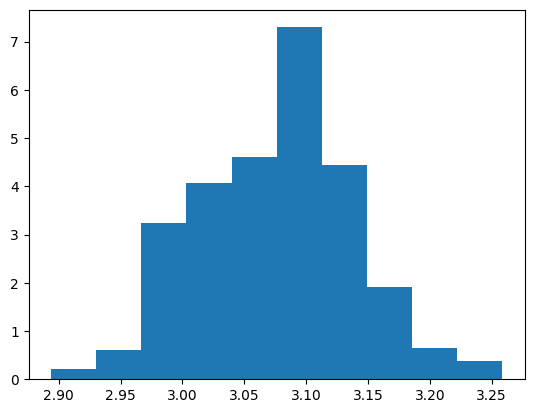

In [30]:
plt.hist(tau_arr, density=True)

In [12]:
# calculate the estimation error 
est_err_M, est_err_M_raw, rel_err_M, rel_err_M_raw = np.zeros(n_iters), np.zeros(n_iters), np.zeros(n_iters), np.zeros(n_iters)
for i in range(n_iters):
    est_err_M[i] = np.linalg.norm(M_arr[i] - b_arr[i], ord="fro")
    est_err_M_raw[i] = np.linalg.norm(M_raw_arr[i] - b_arr[i], ord="fro")
    rel_err_M[i] = est_err_M[i] / np.linalg.norm(b_arr[i], ord="fro")
    rel_err_M_raw[i] = est_err_M_raw[i] / np.linalg.norm(b_arr[i], ord="fro")

(array([ 0.65919404,  2.24125973,  9.36055535, 14.10675242, 18.98478831,
        13.18388077,  5.27355231,  1.7139045 ,  0.13183881,  0.26367762]),
 array([2.18816786, 2.2033379 , 2.21850794, 2.23367798, 2.24884802,
        2.26401806, 2.2791881 , 2.29435814, 2.30952818, 2.32469822,
        2.33986826]),
 <BarContainer object of 10 artists>)

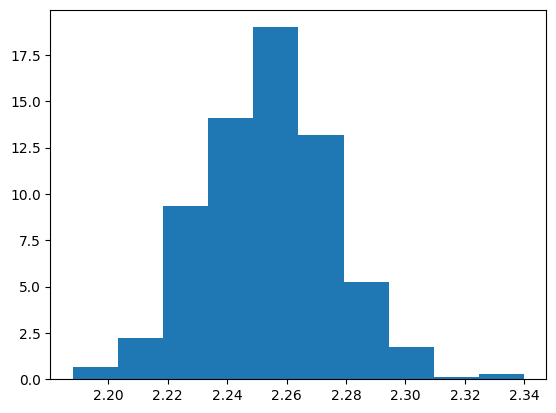

In [13]:
plt.hist(tau_raw_arr, density=True)

(array([ 1.18704237,  3.22197216,  6.44394432,  9.496339  , 10.85295885,
         5.59605691,  2.96760594,  1.8653523 ,  0.67830993,  0.08478874]),
 array([0.54602377, 0.56961181, 0.59319984, 0.61678788, 0.64037592,
        0.66396396, 0.68755199, 0.71114003, 0.73472807, 0.75831611,
        0.78190414]),
 <BarContainer object of 10 artists>)

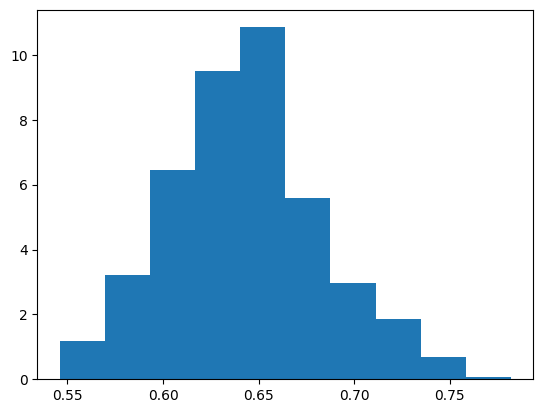

In [14]:
plt.hist(rel_err_M, density=True)

## Projection

## Test base case

In [16]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
seed = 1
#ray.shutdown()
#ray.init()

M_one, tau_one, M_raw_one, tau_raw_one, b_one, t1, t2, l_one = worker_proj.remote(seed, d1, d2, r, tau, noise_sd)

#ray.shutdown()

2023-07-23 16:08:15,495	INFO worker.py:1636 -- Started a local Ray instance.


TypeError: cannot unpack non-iterable ray._raylet.ObjectRef object

In [20]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
seed = 0
#ray.shutdown()
#ray.init()

M, tau, M_raw, tau_raw, b = worker(seed, d1, d2, r, tau, noise_sd)

#ray.shutdown()

> /tmp/ipykernel_2490066/1749465253.py(7)debias()
      5     #print(s[:r+1], r)
      6     pdb.set_trace()
----> 7     u = u[:, :r]
      8     vh = vh[:r, :]
      9     t1 = l * np.sum(Z*(u.dot(vh))) # lambda * <Z, UV^T>



ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(8)debias()
      6     pdb.set_trace()
      7     u = u[:, :r]
----> 8     vh = vh[:r, :]
      9     t1 = l * np.sum(Z*(u.dot(vh))) # lambda * <Z, UV^T>
     10     PTperpZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))



ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(9)debias()
      7     u = u[:, :r]
      8     vh = vh[:r, :]
----> 9     t1 = l * np.sum(Z*(u.dot(vh))) # lambda * <Z, UV^T>
     10     PTperpZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))
     11     t2 = np.sum(PTperpZ**2) # ||PTperpZ||_F^2



ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(10)debias()
      8     vh = vh[:r, :]
      9     t1 = l * np.sum(Z*(u.dot(vh))) # lambda * <Z, UV^T>
---> 10     PTperpZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))
     11     t2 = np.sum(PTperpZ**2) # ||PTperpZ||_F^2
     12 



ipdb>  print(t1)


497.50263151481994


ipdb>  print(Z)


[[0.         0.87788854 0.         ... 0.         0.87788854 0.87788854]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 ...
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.         0.87788854]
 [0.87788854 0.         0.         ... 0.         0.87788854 0.        ]]


ipdb>  print(np.sum(Z))


3874.9999999999995


ipdb>  print(Z*(u.dot(vh)))


[[-0.          0.1219242  -0.         ... -0.          0.1211366
   0.09946439]
 [-0.          0.         -0.         ... -0.          0.
  -0.        ]
 [ 0.04366568  0.04181148 -0.         ... -0.          0.08892411
  -0.        ]
 ...
 [ 0.1118824   0.12949322  0.         ... -0.          0.02264649
  -0.        ]
 [ 0.07114045  0.07888769 -0.         ...  0.         -0.
   0.09178158]
 [ 0.08419776 -0.         -0.         ... -0.          0.07665131
  -0.        ]]


ipdb>  tau


1.0758190193954564


ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(11)debias()
      9     t1 = l * np.sum(Z*(u.dot(vh))) # lambda * <Z, UV^T>
     10     PTperpZ = (np.eye(u.shape[0]) - u.dot(u.T)).dot(Z).dot(np.eye(vh.shape[1]) - vh.T.dot(vh))
---> 11     t2 = np.sum(PTperpZ**2) # ||PTperpZ||_F^2
     12 
     13     #print('PUVZ {}, PUZ {}, PVZ {}, PTperZ {}, Z {}'.format(np.sum((u.T.dot(Z).dot(vh.T))**2), np.sum((u.dot(u.T).dot(Z))**2), np.sum((Z.dot(vh.T.dot(vh)))**2), t2, np.sum(Z**2)))



ipdb>  PTperpZ


array([[ 0.00746664, -0.05473189,  0.04700012, ..., -0.07588464,
         0.00390397,  0.02131749],
       [-0.00128667, -0.01965863,  0.02683666, ..., -0.05823914,
        -0.07071064, -0.0037007 ],
       [-0.00036591, -0.00049349, -0.02864512, ...,  0.00216023,
         0.03390891,  0.03339999],
       ...,
       [-0.05143057,  0.01492093, -0.07366742, ...,  0.009512  ,
         0.02296832, -0.06109389],
       [ 0.0183246 ,  0.05871748, -0.00476046, ..., -0.05979437,
        -0.05760862, -0.02509637],
       [ 0.0438587 , -0.05088484,  0.02321544, ..., -0.03161029,
         0.01475242,  0.00095851]])


ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(14)debias()
     12 
     13     #print('PUVZ {}, PUZ {}, PVZ {}, PTperZ {}, Z {}'.format(np.sum((u.T.dot(Z).dot(vh.T))**2), np.sum((u.dot(u.T).dot(Z))**2), np.sum((Z.dot(vh.T.dot(vh)))**2), t2, np.sum(Z**2)))
---> 14     M_debias = M + l * u.dot(vh) + t1 / t2 * (Z - PTperpZ) # original M_debias
     15     # M_debias = M + t1 / t2
     16     print("t1, t2: ", t1, t2)



ipdb>  t2


12.397486642621299


ipdb>  print(tau - t1 / t2)


-39.05349475654817


ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(16)debias()
     14     M_debias = M + l * u.dot(vh) + t1 / t2 * (Z - PTperpZ) # original M_debias
     15     # M_debias = M + t1 / t2
---> 16     print("t1, t2: ", t1, t2)
     17     return tau - t1 / t2, M_debias
     18 



ipdb>  n


t1, t2:  497.50263151481994 12.397486642621299
> /tmp/ipykernel_2490066/1749465253.py(17)debias()
     15     # M_debias = M + t1 / t2
     16     print("t1, t2: ", t1, t2)
---> 17     return tau - t1 / t2, M_debias
     18 
     19 def DC_PR_with_l(O, Z, l, suggest_tau = 0, eps = 1e-6):



ipdb>  n


--Return--
(-39.05349475654817, array([[-0.30...-0.03935753]]))
> /tmp/ipykernel_2490066/1749465253.py(17)debias()
     15     # M_debias = M + t1 / t2
     16     print("t1, t2: ", t1, t2)
---> 17     return tau - t1 / t2, M_debias
     18 
     19 def DC_PR_with_l(O, Z, l, suggest_tau = 0, eps = 1e-6):



ipdb>  n


> /tmp/ipykernel_2490066/1749465253.py(58)DC_PR_with_suggested_rank()
     56             # print("pre_tau: ", pre_tau)
     57             tau_debias, M_debias = debias(pre_M, pre_tau, Z, l*coef)
---> 58             return M_debias, tau_debias, pre_M, pre_tau
     59         pre_M = M
     60         pre_tau = tau



ipdb>  print(Z)


[[0.         0.87788854 0.         ... 0.         0.87788854 0.87788854]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 ...
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.         0.87788854]
 [0.87788854 0.         0.         ... 0.         0.87788854 0.        ]]


ipdb>  n


--Return--
(array([[-0.30...-0.03935753]]), -39.05349475654817, array([[ 0.14... 0.10620025]]), 1.0758190193954564)
> /tmp/ipykernel_2490066/1749465253.py(58)DC_PR_with_suggested_rank()
     56             # print("pre_tau: ", pre_tau)
     57             tau_debias, M_debias = debias(pre_M, pre_tau, Z, l*coef)
---> 58             return M_debias, tau_debias, pre_M, pre_tau
     59         pre_M = M
     60         pre_tau = tau



ipdb>  n


--Return--
(array([[-0.30...-0.03935753]]), -39.05349475654817, array([[ 0.14... 0.10620025]]), 1.0758190193954564)
> /tmp/ipykernel_2490066/1749465253.py(68)DC_PR_auto_rank()
     64     #print("running starts.")
     65     s = np.linalg.svd(O, full_matrices = False, compute_uv=False)
     66     #print("runs svd for auto rank.")
     67     suggest_r = np.sum(np.cumsum(s**2) / np.sum(s**2) <= 0.998)
---> 68     return DC_PR_with_suggested_rank(O, Z, suggest_r = suggest_r)



ipdb>  n


> /tmp/ipykernel_2490066/1320489511.py(26)worker_proj()
     22     P_Z = h_z_vec.dot(inv(h_z_vec.T.dot(h_z_vec)).dot(h_z_vec.T))
     23     O_corrected = np.reshape(P_Z.dot(outcome_mat.reshape([d1*d2, 1])), [d1, d2])
     24     Z_corrected = np.reshape(P_Z.dot(treat_mat.reshape([d1*d2, 1])), [d1, d2])
     25     M, tau, M_raw, tau_raw = DC_PR_auto_rank(O_corrected, Z_corrected)
---> 26     return M, tau, M_raw, tau_raw, b



ipdb>  print(Z)


*** NameError: name 'Z' is not defined


ipdb>  print(treat_mat)


[[0. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 ...
 [1. 1. 0. ... 0. 1. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]]


ipdb>  print(Z_corrected)


[[0.         0.87788854 0.         ... 0.         0.87788854 0.87788854]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 ...
 [0.87788854 0.87788854 0.         ... 0.         0.87788854 0.        ]
 [0.87788854 0.87788854 0.         ... 0.         0.         0.87788854]
 [0.87788854 0.         0.         ... 0.         0.87788854 0.        ]]


ipdb>  print(np.sum(Z_corrected))


3874.9999999999995


ipdb>  print(np.sum(treat_mat))


3875.0


ipdb>  print(pre_M)


*** NameError: name 'pre_M' is not defined


ipdb>  print(M_raw)


[[ 0.14590504  0.6920117   0.05937998 ...  0.10775511  0.63852075
   0.65375039]
 [ 0.056036   -0.02808995  0.03720211 ...  0.08867766  0.03271528
   0.00599911]
 [ 0.75493931  0.75774933  0.09821205 ...  0.04222533  0.6573163
   0.01052997]
 ...
 [ 0.7035102   0.61612701  0.04458444 ...  0.07729037  0.76370453
   0.16568941]
 [ 0.69764793  0.64876759  0.13618859 ...  0.04500353  0.18346401
   0.70814728]
 [ 0.65490532  0.11954172  0.08295777 ...  0.08319877  0.69297795
   0.10620025]]


ipdb>  u_raw, s_raw, vh_raw = np.linalg.svd(M_raw, full_matrices = False)
ipdb>  print(np.sum(treat_mat*(u_raw.dot(vh_raw)))


*** SyntaxError: unexpected EOF while parsing


ipdb>  print(np.sum(treat_mat*(u_raw.dot(vh_raw))))


390.2135870985397


ipdb>  print(np.sum(Z_corrected*(u_raw.dot(vh_raw))))


390.0762044803349


ipdb>  print((u_raw.dot(vh_raw)).shape)


(100, 100)


ipdb>  UVT = u_raw.dot(vh_raw)
ipdb>  PZUVT = np.reshape(P_Z.dot(UVT.reshape([d1*d2, 1])), [d1, d2])
ipdb>  np.sum(PZUVT)


444.33454621321255


ipdb>  np.sum(Z_corrected*PZUVT)


390.07620448033504


ipdb>  np.sum(UVT)


98.82390196841646


ipdb>  np.sum(Z_corrected*UVT)


390.0762044803349


ipdb>  np.sum(np.ones([100,100])*UVT)


98.82390196841646


ipdb>  np.amax(Z_corrected)


0.8778885364748528


ipdb>  Z_corrected.shape


(100, 100)


ipdb>  np.amin(UVT)


-0.27462228133099215


ipdb>  quit


In [101]:
seed = 0
b, z_vec, treat_mat, outcome_mat = generate_dat(seed, d1, d2, r, tau, noise_sd)
u_t, s_t, vh_t= np.linalg.svd(b, full_matrices = False)
h_z_vec = opt_instrument(z_vec, treat_mat)

In [102]:
P_Z = h_z_vec.dot(inv(h_z_vec.T.dot(h_z_vec)).dot(h_z_vec.T))
b_corrected = np.reshape(P_Z.dot(b.reshape([d1*d2, 1])), [d1, d2])
Z_corrected = np.reshape(P_Z.dot(treat_mat.reshape([d1*d2, 1])), [d1, d2])
u_tc, s_tc, vh_tc = np.linalg.svd(b_corrected, full_matrices = False)
print(np.sum(treat_mat * (u_t @ vh_t)))
print(np.sum(Z_corrected * (u_t @ vh_t)))
print(np.sum(treat_mat * (u_tc @ vh_tc))) # if use BH svd then very large, also the current objective B hat is corresponding to BH
print(np.sum(Z_corrected * (u_tc @ vh_tc)))

-1.153847594006658
-1.7725703679194367
250.58895399884898
295.4108422245108


In [103]:
PTperpZ_t = (np.eye(u_t.shape[0]) - u_t.dot(u_t.T)).dot(Z_corrected).dot(np.eye(vh_t.shape[1]) - vh_t.T.dot(vh_t))

In [105]:
PTperpZ_t

array([[-1.66671613e-32, -5.17923347e-32,  3.16934256e-31, ...,
         3.16677409e-31, -1.52731134e-31, -1.50274665e-31],
       [ 4.74418697e-33, -6.68692804e-32, -2.23261657e-32, ...,
         1.31786833e-31, -3.16845345e-31, -1.43596078e-31],
       [ 2.11208784e-32,  2.96020350e-31, -4.80486532e-31, ...,
         8.66094765e-31,  1.58595570e-31, -1.36907836e-30],
       ...,
       [ 3.78753148e-33, -1.90400529e-31, -4.97468769e-31, ...,
         1.32853975e-31, -3.55477883e-31, -4.14185329e-31],
       [-2.38233975e-32,  3.44156586e-32,  7.52802154e-31, ...,
         3.21091431e-31,  7.27104678e-31,  2.83175046e-31],
       [ 4.12238524e-33,  3.24613855e-31,  3.00556994e-31, ...,
         1.72020859e-31,  3.47027353e-31,  9.91626004e-32]])

In [37]:
print(np.sum(s_t > 1e-4))
print(np.sum(s_tc > 1e-4))

3
100


In [39]:
print(np.linalg.matrix_rank(h_z_vec.reshape([d1,d2])))

100


## Further testing

In [11]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5
n_iters = 100

ray.shutdown()
ray.init()

start_time = time.time()
all_results_proj = ray.get(
   [
       worker_proj.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-08-29 01:51:46,718	INFO worker.py:1636 -- Started a local Ray instance.


In [12]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr_proj = [r[0] for r in all_results_proj]
tau_arr_proj = np.array([r[1] for r in all_results_proj])
M_raw_arr_proj = [r[2] for r in all_results_proj]
tau_raw_arr_proj = np.array([r[3] for r in all_results_proj])
b_arr_proj = [r[4] for r in all_results_proj]
t1_arr_proj = np.array([r[5] for r in all_results_proj])
t2_arr_proj = np.array([r[6] for r in all_results_proj])
tau_mean_proj = np.mean(tau_arr_proj)
tau_sd_proj = np.std(tau_arr_proj)
tau_raw_mean_proj = np.mean(tau_raw_arr_proj)
tau_raw_sd_proj = np.std(tau_raw_arr_proj)
print("tau: ", tau_mean_proj, tau_sd_proj)
print("tau raw: ", tau_raw_mean_proj, tau_raw_sd_proj)

tau:  1.8266167724351947 0.1924905591894671
tau raw:  1.8449670087462997 0.19099058653200937


In [33]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr_proj = [r[0] for r in all_results_proj]
tau_arr_proj = np.array([r[1] for r in all_results_proj])
M_raw_arr_proj = [r[2] for r in all_results_proj]
tau_raw_arr_proj = np.array([r[3] for r in all_results_proj])
b_arr_proj = [r[4] for r in all_results_proj]
t1_arr_proj = np.array([r[5] for r in all_results_proj])
t2_arr_proj = np.array([r[6] for r in all_results_proj])
tau_mean_proj = np.mean(tau_arr_proj)
tau_sd_proj = np.std(tau_arr_proj)
tau_raw_mean_proj = np.mean(tau_raw_arr_proj)
tau_raw_sd_proj = np.std(tau_raw_arr_proj)
print("tau: ", tau_mean_proj, tau_sd_proj)
print("tau raw: ", tau_raw_mean_proj, tau_raw_sd_proj)

tau:  1.8266167724351947 0.1924905591894671
tau raw:  1.8449670087462997 0.19099058653200937


In [20]:
np.save('tau_proj.npy', tau_raw_arr)
np.save('tau_proj_debiased.npy', tau_arr)

In [29]:
duration

242.38184356689453

(array([0.29299554, 0.19533036, 0.78132143, 0.97665179, 2.24629912,
        1.95330358, 2.14863394, 0.68365625, 0.19533036, 0.29299554]),
 array([1.32130087, 1.42369151, 1.52608215, 1.62847279, 1.73086343,
        1.83325406, 1.9356447 , 2.03803534, 2.14042598, 2.24281662,
        2.34520725]),
 <BarContainer object of 10 artists>)

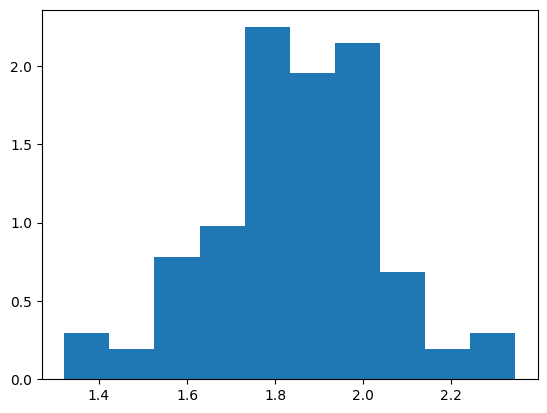

In [34]:
#bin_width = 0.1
#bins = int((np.amax(tau_arr) - np.min(tau_arr))/bin_width)
plt.hist(tau_raw_arr_proj, density=True)

(array([ 0.08926831,  0.62487818,  2.85658597,  8.65902622, 12.22975868,
        11.6048805 ,  5.35609869,  2.58878103,  0.53560987,  0.08926831]),
 array([1.88485549, 1.90725986, 1.92966422, 1.95206859, 1.97447296,
        1.99687733, 2.01928169, 2.04168606, 2.06409043, 2.08649479,
        2.10889916]),
 <BarContainer object of 10 artists>)

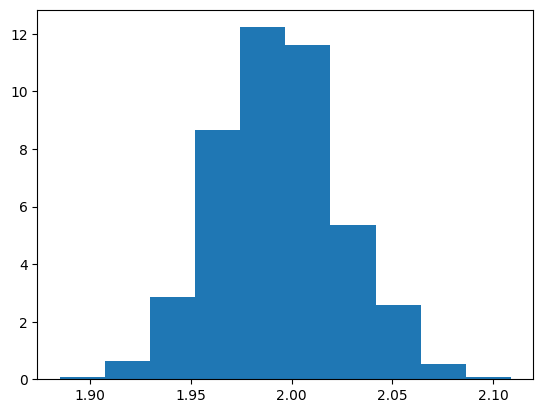

In [13]:
#bin_width = 0.2
#bins = int((np.amax(tau_raw_arr) - np.min(tau_raw_arr))/bin_width)
plt.hist(tau_raw_arr, density=True)

(array([0.05839803, 0.05839803, 0.03893202, 0.1751941 , 0.09733005,
        0.19466011, 0.42825224, 1.28475671, 2.49164937, 0.85650447]),
 array([0.10509031, 0.28102042, 0.45695054, 0.63288065, 0.80881077,
        0.98474089, 1.160671  , 1.33660112, 1.51253124, 1.68846135,
        1.86439147]),
 <BarContainer object of 10 artists>)

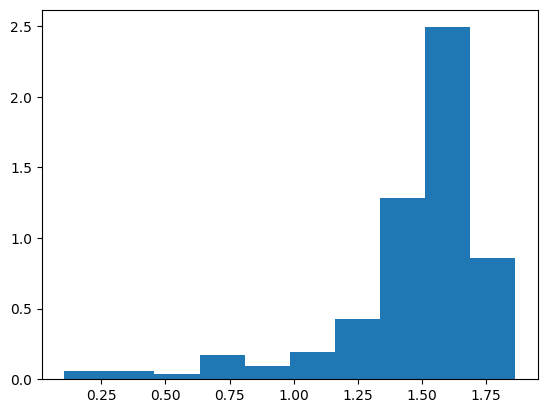

In [28]:
plt.hist(tau_arr[tau_arr>0], density=True)

## Test for Z $\circ$ B

In [13]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5 # change it to 0?
n_iters = 500

ray.shutdown()
ray.init()

start_time = time.time()
all_results_proj = ray.get(
   [
       worker_cmm.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-08-29 01:54:34,374	INFO worker.py:1636 -- Started a local Ray instance.


In [14]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr_proj = [r[0] for r in all_results_proj]
tau_arr_proj = np.array([r[1] for r in all_results_proj])
M_raw_arr_proj = [r[2] for r in all_results_proj]
tau_raw_arr_proj = np.array([r[3] for r in all_results_proj])
b_arr_proj = [r[4] for r in all_results_proj]
t1_arr_proj = np.array([r[5] for r in all_results_proj])
t2_arr_proj = np.array([r[6] for r in all_results_proj])
tau_mean_proj = np.mean(tau_arr_proj)
tau_sd_proj = np.std(tau_arr_proj)
tau_raw_mean_proj = np.mean(tau_raw_arr_proj)
tau_raw_sd_proj = np.std(tau_raw_arr_proj)
print("tau: ", tau_mean_proj, tau_sd_proj)
print("tau raw: ", tau_raw_mean_proj, tau_raw_sd_proj)

tau:  2.142625533343188 0.19527740738456711
tau raw:  2.1414011096404213 0.1817467510962124


In [4]:
#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M_arr_proj = [r[0] for r in all_results_proj]
tau_arr_proj = np.array([r[1] for r in all_results_proj])
M_raw_arr_proj = [r[2] for r in all_results_proj]
tau_raw_arr_proj = np.array([r[3] for r in all_results_proj])
b_arr_proj = [r[4] for r in all_results_proj]
t1_arr_proj = np.array([r[5] for r in all_results_proj])
t2_arr_proj = np.array([r[6] for r in all_results_proj])
tau_mean_proj = np.mean(tau_arr_proj)
tau_sd_proj = np.std(tau_arr_proj)
tau_raw_mean_proj = np.mean(tau_raw_arr_proj)
tau_raw_sd_proj = np.std(tau_raw_arr_proj)
print("tau: ", tau_mean_proj, tau_sd_proj)
print("tau raw: ", tau_raw_mean_proj, tau_raw_sd_proj)

tau:  2.142393925708927 0.21789950334953972
tau raw:  2.1378355305732306 0.196229455818129


(array([0.08248151, 0.08248151, 0.49488908, 0.5773706 , 1.48466725,
        1.97955634, 2.06203785, 1.23722271, 0.08248151, 0.16496303]),
 array([1.46323739, 1.58447667, 1.70571596, 1.82695525, 1.94819454,
        2.06943382, 2.19067311, 2.3119124 , 2.43315169, 2.55439097,
        2.67563026]),
 <BarContainer object of 10 artists>)

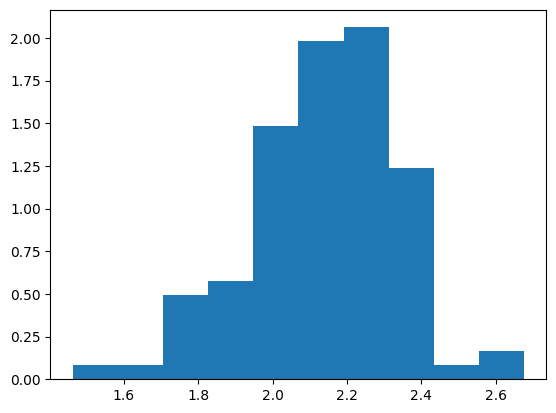

In [6]:
plt.hist(tau_raw_arr_proj, density=True)

(array([0.07906475, 0.07906475, 0.31625901, 0.94877703, 1.58129505,
        1.73942456, 1.73942456, 0.86971228, 0.31625901, 0.23719426]),
 array([1.44719107, 1.57366968, 1.70014829, 1.8266269 , 1.9531055 ,
        2.07958411, 2.20606272, 2.33254133, 2.45901994, 2.58549855,
        2.71197716]),
 <BarContainer object of 10 artists>)

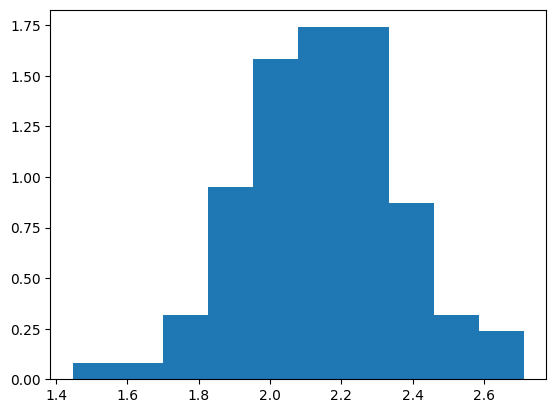

In [7]:
plt.hist(tau_arr_proj, density=True)

## Test for 2SLS

In [3]:
d1 = 100
d2 = 100
r = 3

tau = 2
noise_sd = 0.5 # change it to 0?
n_iters = 500

ray.shutdown()
ray.init()

start_time = time.time()
all_results_2sls = ray.get(
   [
       worker_2sls.remote(seed, d1, d2, r, tau, noise_sd) for seed in range(n_iters)
   ]
).copy()
ray.shutdown()
duration = time.time() - start_time

2023-08-29 01:31:03,622	INFO worker.py:1636 -- Started a local Ray instance.


In [7]:
tau_arr_2sls = [r[0] for r in all_results_2sls]

In [9]:
tau_arr_2sls_mean = np.mean(tau_arr_2sls)
tau_arr_2sls_std = np.std(tau_arr_2sls)

In [10]:
print("2sls mean: ", tau_arr_2sls_mean)
print("2sls std: ", tau_arr_2sls_std)

2sls mean:  2.0000791391603143
2sls std:  0.1919080222511625
